## Wstęp do uczenia maszynowego 
### Praca domowa 5
#### Jakub Piwko, Malwina Wojewoda 
zespół walidujący Patryka Rakusa i Łukasza Tomaszewskiego
***

### Pakiety

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

### Wczytanie i analiza danych

In [2]:
X = pd.read_csv('urbanGB.txt', names = ['x','y'], header=None)

In [3]:
X.head()

,x,y
0,-0.310990,53.7802
1,-3.112550,55.8706
2,-0.088533,51.3806
3,-0.326795,51.4476
4,-3.946530,51.6594


Jako, że mamy do czynienia ze współrzędymi kartograficznymi, odlegości między punktami, które będziemy obliczać mogą być nieprecyzyjne ze względu na zakrzywienie ziemi. W opisie danych dodano wskazówkę, aby przemnożyć dlugość geograficzną przez wskaźnik 1.7, aby uzyskać najbardziej przybliżone odległości. 

Budowniczy nie zdecydowali się na ten krok, dlatego my spróbujemy dokonać zmian, aby porównać wyniki. 

In [4]:
X.x = 1.7 * X.x

In [5]:
X.head()

,x,y
0,-0.528683,53.7802
1,-5.291335,55.8706
2,-0.150506,51.3806
3,-0.555551,51.4476
4,-6.709101,51.6594


In [6]:
X = X.to_numpy()

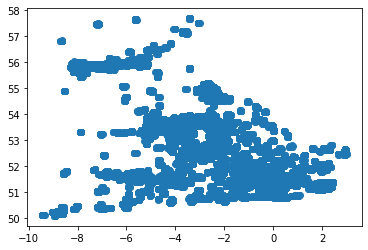

In [7]:
plt.scatter(X[:,0],X[:,1])
plt.show()

### KMean i metoda łokcia 

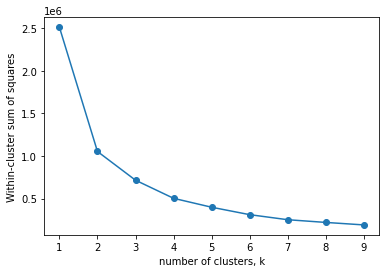

In [8]:
ks = range(1, 10)
scores = []

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(X)
    scores.append(model.score(X) * -1)
    
plt.plot(ks, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Within-cluster sum of squares')
plt.xticks(ks)
plt.show()

Budowniczy wykorzystali metodą łokcia do znalezienia optymalnej liczby klastrów. Według ich interepretacji, punkt przegięcia i tym samym podział wypada dla liczby klastrów 4 lub 5. My sprawdzimy jeszcze dla wartości 3.

In [9]:
def plot_kmeans_clusters(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=30, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-means clusters')
    plt.show()

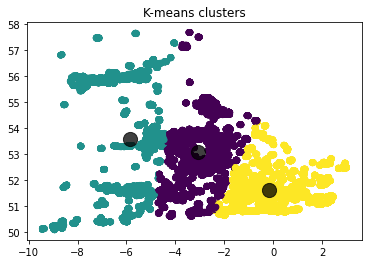

In [10]:
plot_kmeans_clusters(X, n_clusters=3)

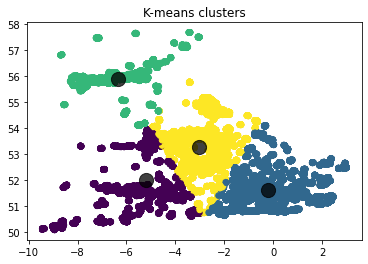

In [11]:
plot_kmeans_clusters(X, n_clusters=4)

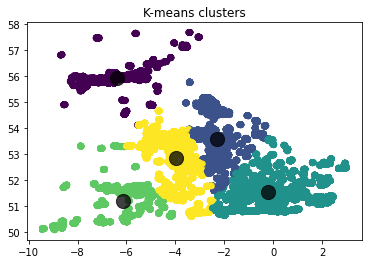

In [12]:
plot_kmeans_clusters(X, n_clusters=5)

Po przeskalowaniu długości geograficznej można dostrzec, że klastry zbudowały się odrobinę inaczej. Nadal aktualny jest wniosek, że 4 i 5 klastrów dzieli lepiej punkty w grupy.

#### Metoda silhouette

Spróbujemy jeszcze zbadać optymalną liczbę klastrów metodą silhouette. Ze względu na dużą złożoność obliczeniową spróbujemy przeprowadzić dobór na zmniejszonym zbiorze.

In [13]:
df = pd.DataFrame(X, columns=['x', 'y'])
df = df.sample(frac=0.05, random_state=42).astype('float32')

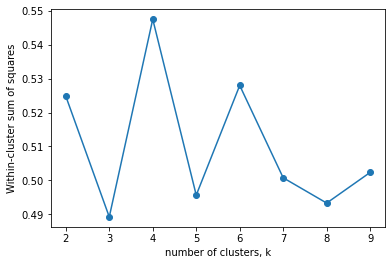

In [14]:
ks = range(2, 10)
scores = []

for k in ks:
    model = KMeans(n_clusters = k)
    labels = model.fit_predict(df)
    scores.append(silhouette_score(df, labels))
    
plt.plot(ks, scores, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Within-cluster sum of squares')
plt.xticks(ks)
plt.show()

CO TU SIĘ...

### Klasteryzacja hierarchiczna

Budowniczy wykorzystali metodę aglomeracyjną. Ona także ma dużą złożoność obliczeniową, więc tak samo jak zespół budujący, wykorzystamy pomniejszony zbiór, aby sprawdzić czy skalowanie zmiennych daje duże różnice. 

In [15]:
df = pd.DataFrame(X, columns=['x', 'y'])
df = df.sample(frac=0.05, random_state=42).astype('float32')

In [16]:
Z = hierarchy.linkage(df_MA, method='ward')

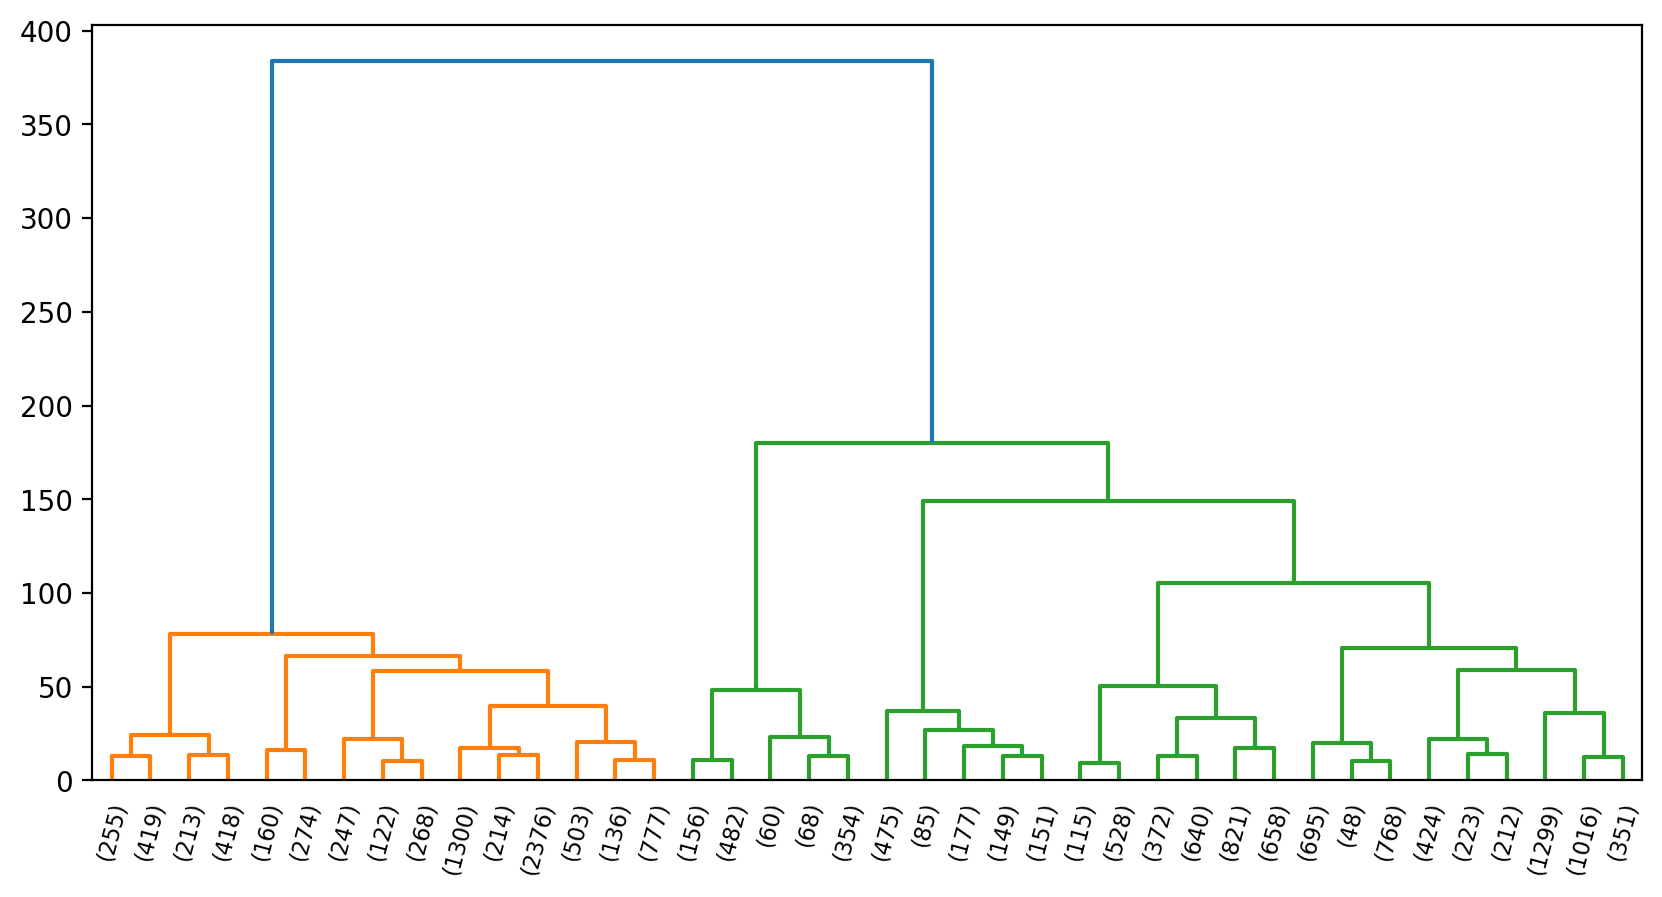

In [17]:
plt.figure(figsize=(10, 3), dpi= 200, facecolor='w', edgecolor='k')
hierarchy.dendrogram(Z, p=40, truncate_mode='lastp', leaf_rotation=75)
plt.show()

Wnioski są podobne, że najlepiej podzielić nasz zbiór na 4 lub 5 klastrów, również po przeskalowaniu. 

Budowniczy zdecydowali się w kolejnym kroku na klasteryzację aglomeracyjną z wykorzystaniem progu odległości. 

In [18]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=100, linkage='ward')
y = model.fit_predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

MemoryError: Unable to allocate 483. GiB for an array with shape (64863555576,) and data type float64

Bez skalowania dla threshold równego 100 budowniczy uzyskali 4 klastry, po skalowaniu jest ich 5.

In [ ]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=60, linkage='ward')
y = model.fit_predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Przy progu wynoszącym 60 dla naszych danych model wyznaczył aż 8 klastrów. U budwoniczych było tylko 5. Pokazuje to, że dla metody z ustawianiem thresholdu duże znaczenie ma przeskalowanie długości geograficznej. W naszym przypadku lepiej byłoby wybrać większe wartości progu. Dal 100 klasteryzacja wygląda przystępnie. 

Budowniczy w swoim raporcie wykorzystali aglomeracyjną metodą klasteryzacji z połączeniem typu 'ward'. My spróbujemy jeszcze hierarchizacji dla 5 klastrów z połączeniem typu: 'complete', 'average' i 'single'.

In [ ]:
model = AgglomerativeClustering(n_clusters=5, linkage='complete')
y = model.fit_predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

In [ ]:
model = AgglomerativeClustering(n_clusters=5, linkage='average')
y = model.fit_predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

In [ ]:
model = AgglomerativeClustering(n_clusters=5, linkage='single')
y = model.fit_predict(df)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=y, s=30, cmap='viridis')
plt.show()

Widać, że wybór 'ward' w metodzie łączenia przez budowniczych było uzasadnione bo inne metody łączą w nieproporcjonalne klastry lub klastry, które nie pokrywają się z faktycznym położeniem grup na wykresie. 

### Dopasowanie do mapy Wielkiej Brytanii

### PRÓBA NA RAZIE :')

In [ ]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
im = plt.imread("mapa1.png")
fig, ax = plt.subplots()
im = ax.imshow(im, extent=[0, 300, 0, 300])
x = np.array(range(300))
ax.plot(x, x, ls='dotted', linewidth=2, color='red')
plt.show()

### K-medoids

Mimo, że w budowie nie została wykorzystana ta metoda uznaliśmy, że warto też przetesować jakie dałaby wyniki. W tym przypadku również wykorzystamy mniejszą próbkę danych.

In [ ]:
def plot_kmedoids_clusters(X, n_clusters):
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=0)
    kmedoids.fit(X)
    y_kmedoids = kmedoids.predict(X)
    plt.scatter(X[:, 0], X[:, 1], c=y_kmedoids, s=30, cmap='viridis')

    centers = kmedoids.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75)
    plt.title('K-medoids clusters')
    plt.show()

In [ ]:
df_KM = df.sample(frac=0.05, random_state=42).astype('float32')
plot_kmedoids_clusters(df.sample(frac=0.05, random_state=42).astype('float32')